In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

root_dir = "/content/drive/My Drive/head-detection-yolov3-pytorch/notebooks"
%cd "{root_dir}"
!pip install -r ../requirements.txt

In [0]:
import sys
sys.path.append("..")

import torch
from torch.utils.data import DataLoader
from utils.utils import *
import argparse
import json
from utils.datasets import ScutHeadDataset, pad_to_square
from models import Darknet
from tqdm import tqdm
from utils.plot import draw_prediction, add_xyxy_bboxes
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.plot import draw_tracking_state
from utils.tracking import TrackingState, Tracklet

from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
# model_checkpoint = '../output/3exp__b_32_grad_1__lr_0.0001__frozen__/checkpoints/yolov3_epoch_9.pth'
exp_name = "exp__b_16_grad_4__lr_1.0e-04__aug__"
model_checkpoint = f'../output/{exp_name}/checkpoints/yolov3_epoch_29.pth'

model_config = '../config/models/yolov3.cfg'

device = torch.device("cuda")
model = Darknet(model_config).to(device)
model.load_state_dict(torch.load(model_checkpoint))
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

## Profiling

In [0]:
import torch
import torchvision.models as models

x = torch.randn((1, 3, 446, 446), requires_grad=True).to(device)

with torch.autograd.profiler.profile(use_cuda=True) as prof:
    model(x)
print(prof) 

--------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------
Name                        Self CPU total %   Self CPU total      CPU total %        CPU total     CPU time avg     CUDA total %       CUDA total    CUDA time avg  Number of Calls
--------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------
conv2d                                0.24%          1.717ms            0.24%          1.717ms          1.717ms            0.24%          2.801ms          2.801ms                1
convolution                           0.23%          1.636ms            0.23%          1.636ms          1.636ms            0.23%          2.670ms          2.670ms                1
_convolution                          0.22%          1.563ms            0.22%          1.563ms     

In [0]:
x = torch.randn((1, 3, 446, 446), requires_grad=True).to(device)

In [0]:
%%timeit -r 10
model(x)

221 ms ± 19.9 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [0]:
%%timeit -r 10
model.predict(image)

431 ms ± 40.8 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [0]:
%%timeit -r 10
img = torch.from_numpy(np.array(image)).float().permute(2,0,1)

23.8 ms ± 1.68 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [0]:
img = torch.from_numpy(np.array(image)).float().permute(2,0,1)

In [0]:
%%timeit -r 10
padded_img, pad = pad_to_square(img)

36.6 ms ± 13.4 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [0]:
padded_img, pad = pad_to_square(img)

In [0]:
%%timeit -r 10
warped_img = F.interpolate(padded_img.unsqueeze(0), size=446, mode="nearest").squeeze(0)

22.9 ms ± 4.64 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [0]:
warped_img = F.interpolate(padded_img.unsqueeze(0), size=446, mode="nearest").squeeze(0)

In [0]:
%%timeit -r 10
warped_img.unsqueeze(0).to(device)

1.26 ms ± 159 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [0]:
%%timeit -r 10
model(warped_img.unsqueeze(0).to(device))

271 ms ± 50.2 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [0]:
warped_img = F.interpolate(padded_img.unsqueeze(0), size=224, mode="nearest").squeeze(0)

In [0]:
%%timeit -r 10
model(warped_img.unsqueeze(0).to(device))

241 ms ± 36.7 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [0]:
result = model(warped_img.unsqueeze(0).to(device))

In [0]:
%%timeit -r 10
non_max_suppression(result, conf_thres=0.5, nms_thres=0.3)

KeyboardInterrupt: 

# Single image test

In [0]:
image = Image.open(
            "test_image.png"
        ).convert('RGB')
pred_bboxes = model.predict(image)

<Figure size 576x576 with 0 Axes>

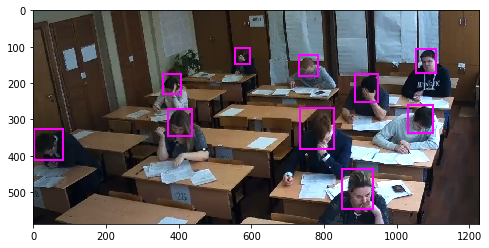

In [0]:
plt.rcParams['figure.figsize'] = [8, 8]

plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(image)

add_xyxy_bboxes(ax, pred_bboxes[:, :4], color=(1,0,1))

plt.show()

# Видео тест

In [0]:

import cv2
from tqdm import tqdm_notebook


data_dir= '/content/drive/My Drive/Datasets/'
# data_dir= 'C:/Users/admin/Google Drive/Datasets'

# video_file = f'{data_dir}/classroom/11-30-00.mp4'
# video_file = 'C:/Users/admin/Google Drive/Datasets/classroom/146688666.mp4'
# video_file = 'E:/Datasets/Видео БГ/006 Кирова-Марата_23_05_2019 19.05.00.mcm'
video_reader = cv2.VideoCapture(video_file)

In [0]:
_, image = video_reader.read()

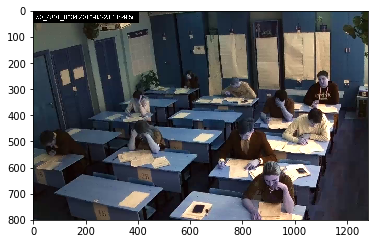

In [7]:
plt.imshow(image)

In [0]:
# START_TIME = 15*60*1000+0*1000
START_TIME = 10 * 1000
FRAMES_NUM = 1000

conf = 0.6
nms =0.2
video_out = video_file[:-4] + f'_detected_pytorch_conf_{conf}_nms_{nms}' + '.mp4'
video_reader = cv2.VideoCapture(video_file)

video_reader.set(cv2.CAP_PROP_POS_MSEC, START_TIME)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

img_size = 446
video_writer = cv2.VideoWriter(video_out,
                       cv2.VideoWriter_fourcc(*'MPEG'), 
                       20.0, 
                       (img_size, img_size))

boxes_list = []

sigma_l = 0.2

for i in tqdm_notebook(range(FRAMES_NUM)):
    _, image = video_reader.read()

    img = torch.from_numpy(np.array(image)).float().permute(2,0,1).to(device)
    padded_img, pad = pad_to_square(img)
    warped_img = F.interpolate(padded_img.unsqueeze(0), size=img_size, mode="nearest").squeeze(0)
    result = model(warped_img.unsqueeze(0).to(device))
    outputs = non_max_suppression(result, conf_thres=conf, nms_thres=nms)
    
    warped_img = warped_img.int().permute(1,2,0).cpu().numpy()
    i2 = warped_img.copy()
    
    if outputs[0] is not None:
        for box in outputs[0]:

            xmin, ymin, xmax, ymax = box[:4]

            cv2.rectangle(i2, (xmin,ymin), (xmax,ymax), (255,255,0), 2)
        
    video_writer.write(np.uint8(i2))
    
    # boxes_list.append(result)
    
video_writer.release()
video_reader.release()

In [0]:
def track_video(video_file, start_time=0, frames_num=1000, fps=25.0, conf_thres=0.6, nms_thres=0.2, trail_size=None, print_text=False):


    video_out = video_file[:-4] + f'_detected_pytorch_conf_{conf_thres}_nms_{nms_thres}' + '.mp4'
    video_reader = cv2.VideoCapture(video_file)

    video_reader.set(cv2.CAP_PROP_POS_MSEC, start_time)

    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

    video_writer = cv2.VideoWriter(video_out,
                           cv2.VideoWriter_fourcc(*'MPEG'), 
                           25.0, 
                           (frame_w, frame_h))

    boxes_list = []

    tracking_state = TrackingState(
        sigma_h=0.5,
        sigma_iou=0.3,
        min_length=5,
        max_lost_time=10,
    )

    for i in tqdm_notebook(range(frames_num)):
        _, image = video_reader.read()

        pred_bboxes = model.predict(image, conf_thres=conf_thres, nms_thres=nms_thres)
        tracking_state.update_tracks(np.array(pred_bboxes))
        image = draw_tracking_state(image, tracking_state, trail_size=trail_size, print_text=print_text)

        video_writer.write(np.uint8(image))

    video_writer.release()
    video_reader.release()

In [42]:
import os

vid_dir = f'{data_dir}/Видео БГ'
for video_file in os.listdir(vid_dir):
    if video_file.endswith(".mcm"):
        print(video_file)
        video_file = os.path.join(vid_dir, video_file)
        track_video(video_file, frames_num=2000, print_text=False)

028 До Театра 1_23_05_2019 19.05.00.mcm



016 Кирова - Рылеева_26_05_2019 12.05.00.mcm



035 Моск. пл 2_28_05_2019 16.05.00.mcm



028 До Театра 1_26_05_2019 19.05.00.mcm



012 Кирова пл. Театральная_26_05_2019 07.05.00.mcm



016 Кирова - Рылеева_25_05_2019 12.05.00.mcm



006 Кирова-Марата_23_05_2019 19.05.00.mcm



012 Кирова пл. Театральная_23_05_2019 19.05.00.mcm



006 Кирова-Марата_24_05_2019 13.05.00.mcm


In [0]:
track_video(f'{data_dir}/Видео БГ/006 Кирова-Марата_23_05_2019 19.05.00.mcm', frames_num=40, print_text=False)